In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

##### Reading the csv file

In [3]:
# Reading a csv file
cities=pd.read_csv('cities_c.csv')
cities.head()

,id,name,month,average,parameter,parameterId,displayName,unit,first_datetime,last_datetime
0,2402,SAN BORJA,2/1/2018,54.548000,pm10,1,PM10,µg/m³,2018-02-19T17:00:00Z,2018-02-23T06:00:00Z
1,2402,SAN BORJA,3/1/2018,43.410441,pm10,1,PM10,µg/m³,2018-03-01T07:00:00Z,2018-03-14T07:00:00Z
2,2402,SAN BORJA,4/1/2018,64.367201,pm10,1,PM10,µg/m³,2018-04-11T17:00:00Z,2018-05-01T00:00:00Z
3,2402,SAN BORJA,5/1/2018,69.778412,pm10,1,PM10,µg/m³,2018-05-01T01:00:00Z,2018-06-01T00:00:00Z
4,2402,SAN BORJA,6/1/2018,32.979294,pm10,1,PM10,µg/m³,2018-06-01T01:00:00Z,2018-07-01T00:00:00Z


##### Here we are dropping the columns that we don't need for the analysis

In [4]:
# Dropping unnecessary columns
cities=cities.drop(['first_datetime', 'last_datetime'], axis=1)
# Checking the first few rows
cities.head()

,id,name,month,average,parameter,parameterId,displayName,unit
0,2402,SAN BORJA,2/1/2018,54.548000,pm10,1,PM10,µg/m³
1,2402,SAN BORJA,3/1/2018,43.410441,pm10,1,PM10,µg/m³
2,2402,SAN BORJA,4/1/2018,64.367201,pm10,1,PM10,µg/m³
3,2402,SAN BORJA,5/1/2018,69.778412,pm10,1,PM10,µg/m³
4,2402,SAN BORJA,6/1/2018,32.979294,pm10,1,PM10,µg/m³


##### Checking for duplicate values

In [5]:
# Check for duplicated rows
duplicates = cities[cities.duplicated(keep=False)]

# Display the duplicated rows
print(duplicates)

Empty DataFrame
Columns: [id, name, month, average, parameter, parameterId, displayName, unit]
Index: []


##### Modifying the months column

In [6]:
# Creating a dataframe
cities = pd.DataFrame(cities)

# Convert the 'month' column to datetime
cities['month']=pd.to_datetime(cities['month'])

# Apply strftime to the 'month' column to format it as "Month Year"
cities['formatted_month'] = cities['month'].dt.strftime('%B %Y')

# Checking on few rows
cities.head()

,id,name,month,average,parameter,parameterId,displayName,unit,formatted_month
0,2402,SAN BORJA,2018-02-01,54.548000,pm10,1,PM10,µg/m³,February 2018
1,2402,SAN BORJA,2018-03-01,43.410441,pm10,1,PM10,µg/m³,March 2018
2,2402,SAN BORJA,2018-04-01,64.367201,pm10,1,PM10,µg/m³,April 2018
3,2402,SAN BORJA,2018-05-01,69.778412,pm10,1,PM10,µg/m³,May 2018
4,2402,SAN BORJA,2018-06-01,32.979294,pm10,1,PM10,µg/m³,June 2018


In [7]:
# Removing the previous 'month' column
cities=cities.drop('month',axis=1)
cities.head()
  

,id,name,average,parameter,parameterId,displayName,unit,formatted_month
0,2402,SAN BORJA,54.548000,pm10,1,PM10,µg/m³,February 2018
1,2402,SAN BORJA,43.410441,pm10,1,PM10,µg/m³,March 2018
2,2402,SAN BORJA,64.367201,pm10,1,PM10,µg/m³,April 2018
3,2402,SAN BORJA,69.778412,pm10,1,PM10,µg/m³,May 2018
4,2402,SAN BORJA,32.979294,pm10,1,PM10,µg/m³,June 2018


In [8]:
# Splitting the formatted_month column to month and year
cities[['months','year']] = cities['formatted_month'].str.split(' ',expand=True)
cities 

# Removing the formatted_month column
cities = cities.drop('formatted_month',axis=1)
cities.head()

# Export the DataFrame to a CSV file
csv_file_path = 'cities_modified.csv'
cities.to_csv(csv_file_path, index=False)

#### Origanizing the dataframe in a way that the parameters are the columns

In [9]:
# Step 1: Assess data completeness
completeness = cities.groupby(['name', 'parameter'])['average'].count().unstack()
print("Data completeness (number of measurements):")
print(completeness)

# Calculate the percentage of missing data for each city-parameter combination
missing_percentage = (1 - completeness.divide(completeness.max())) * 100
print("\nPercentage of missing data:")
print(missing_percentage)

# Step 2: Filter out parameters or cities with too much missing data
threshold = 50
valid_parameters = missing_percentage.columns[missing_percentage.mean() < threshold]
valid_cities = missing_percentage.index[missing_percentage.mean(axis=1) < threshold]

# Filter the original dataset
cities_filtered = cities[
    (cities['name'].isin(valid_cities)) & 
    (cities['parameter'].isin(valid_parameters))
]

# Step 3: Handle remaining missing values
cities_pivoted = cities_filtered.pivot_table(
    index=['name', 'months', 'year'],
    columns='parameter',
    values='average'
).reset_index()

cities_cleaned = cities_pivoted.groupby('name').apply(
    lambda x: x.sort_values(['year', 'months']).ffill()
).reset_index(drop=True)

# Convert 'months' to datetime for proper sorting
cities_cleaned['date'] = pd.to_datetime(cities_cleaned['year'].astype(str) + ' ' + cities_cleaned['months'], format='%Y %B')
cities_cleaned = cities_cleaned.sort_values(['name', 'date'])

print("\nCleaned data shape:", cities_cleaned.shape)
print(cities_cleaned.head())

# Get the list of parameters
parameters = cities_cleaned.columns.drop(['name', 'months', 'year', 'date'])

# Export the resulting DataFrame to a CSV file
cities_cleaned.to_csv('cleaned_cities_data.csv', index=False)

Data completeness (number of measurements):
parameter                 co   no2    o3  pm10  pm25   so2
name                                                      
AARSCHOT                 NaN  79.0  79.0  79.0  79.0   NaN
Augsburg/Bourges-Platz   NaN  78.0  78.0  78.0  78.0   NaN
CUENCA                   NaN  78.0  78.0   NaN   NaN  78.0
SAN BORJA               44.0  55.0  55.0  51.0  51.0  51.0

Percentage of missing data:
parameter                co        no2         o3       pm10       pm25  \
name                                                                      
AARSCHOT                NaN   0.000000   0.000000   0.000000   0.000000   
Augsburg/Bourges-Platz  NaN   1.265823   1.265823   1.265823   1.265823   
CUENCA                  NaN   1.265823   1.265823        NaN        NaN   
SAN BORJA               0.0  30.379747  30.379747  35.443038  35.443038   

parameter                     so2  
name                               
AARSCHOT                      NaN  
Augsburg/Bourg

C:\Users\admin\AppData\Local\Temp\ipykernel_32284\107331121.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cities_cleaned = cities_pivoted.groupby('name').apply(


##### Dropping parameters that don't have enough data

In [10]:
# Drop specified columns
new= pd.read_csv('cleaned_cities_data.csv')
new.drop(columns=['co', 'so2'], inplace=True, errors='ignore')

# Drop rows where 'name' is 'CUNECA'
new = new[new['name'] != 'CUENCA']

# Export the resulting DataFrame to a CSV file
new.to_csv('final_new.csv', index=False)
new.head()

,name,months,year,no2,o3,pm10,pm25,date
0,AARSCHOT,January,2018,18.520325,47.944444,17.916598,10.471374,2018-01-01
1,AARSCHOT,February,2018,23.589080,37.849650,31.124684,21.776243,2018-02-01
2,AARSCHOT,March,2018,14.697917,51.393939,23.637288,13.893782,2018-03-01
3,AARSCHOT,April,2018,17.272388,67.107843,38.572662,24.731013,2018-04-01
4,AARSCHOT,May,2018,16.310345,51.397436,30.250000,18.900000,2018-05-01


##### Calculating AQI

In [11]:
def calculate_aqi(concentration, breakpoints):
    for low, high, i_low, i_high in breakpoints:
        if low <= concentration <= high:
            return ((i_high - i_low) / (high - low)) * (concentration - low) + i_low
    return None

def calculate_overall_aqi(row, breakpoints):
    aqi_values = []
    for pollutant in ['pm25', 'pm10', 'o3', 'no2']:
        if pd.notnull(row[pollutant]):
            aqi = calculate_aqi(row[pollutant], breakpoints[pollutant])
            if aqi is not None:
                aqi_values.append(aqi)
    return max(aqi_values) if aqi_values else None

# Load your CSV file
realD = pd.read_csv('final_new.csv')  # Replace with your actual file name

# Define the breakpoints
breakpoints = {
    'pm25': [(0.0, 42.0, 0, 50), (42.1, 84.0, 51, 100), (84.1, 126.0, 101, 150), 
             (126.1, 168.0, 151, 200), (168.1, 210.0, 201, 300)],
    'pm10': [(0.0, 54.0, 0, 50), (55.1, 154.0, 51, 100), (155.0, 254.0, 101, 150), 
             (255.0, 354.0, 151, 200), (355.0, 424.0, 201, 300)],
    'o3': [(0.0, 26.67, 0, 50), (26.68, 53.33, 51, 100), (53.34, 80.0, 101, 150), 
           (80.01, 106.67, 151, 200), (106.68, 133.33, 201, 300), (133.34, 160.0, 301, 500)],
    'no2': [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), 
            (361, 649, 151, 200), (650, 1249, 201, 300), (1250, 1649, 301, 400), 
            (1650, 2049, 401, 500)]
}

# Calculate AQI for each pollutant and overall AQI
for pollutant in ['pm25', 'pm10', 'o3', 'no2']:
    realD[f'{pollutant}_aqi'] = realD[pollutant].apply(lambda x: calculate_aqi(x, breakpoints[pollutant]))

realD['overall_aqi'] = realD.apply(lambda row: calculate_overall_aqi(row, breakpoints), axis=1)

# Save the results
realD.to_csv('aqi_results.csv', index=False)

print(realD.head())  # Display the first few rows of the results

       name    months  year        no2         o3       pm10       pm25  \
0  AARSCHOT   January  2018  18.520325  47.944444  17.916598  10.471374   
1  AARSCHOT  February  2018  23.589080  37.849650  31.124684  21.776243   
2  AARSCHOT     March  2018  14.697917  51.393939  23.637288  13.893782   
3  AARSCHOT     April  2018  17.272388  67.107843  38.572662  24.731013   
4  AARSCHOT       May  2018  16.310345  51.397436  30.250000  18.900000   

         date   pm25_aqi   pm10_aqi      o3_aqi    no2_aqi  overall_aqi  
0  2018-01-01  12.465921  16.589442   90.097853  17.472005    90.097853  
1  2018-02-01  25.924099  28.819151   71.537068  22.253849    71.537068  
2  2018-03-01  16.540217  21.886378   96.440264  13.865959    96.440264  
3  2018-04-01  29.441682  35.715428  126.304738  16.294706   126.304738  
4  2018-05-01  22.500000  28.009259   96.446693  15.387118    96.446693  


##### Rounding the values of the AQI

In [12]:
# Drop specified columns
rnew= pd.read_csv('aqi_results.csv')
rnew.drop(columns=['pm10', 'pm25','no2','o3'], inplace=True, errors='ignore')

# Round the average column
rnew[['pm25_aqi','pm10_aqi','o3_aqi','no2_aqi','overall_aqi']] = rnew[['pm25_aqi','pm10_aqi','o3_aqi','no2_aqi','overall_aqi']].round()

# Export the resulting DataFrame to a CSV file
rnew.to_csv('aqii_results.csv', index=False)
rnew.head()

,name,months,year,date,pm25_aqi,pm10_aqi,o3_aqi,no2_aqi,overall_aqi
0,AARSCHOT,January,2018,2018-01-01,12.0,17.0,90.0,17.0,90.0
1,AARSCHOT,February,2018,2018-02-01,26.0,29.0,72.0,22.0,72.0
2,AARSCHOT,March,2018,2018-03-01,17.0,22.0,96.0,14.0,96.0
3,AARSCHOT,April,2018,2018-04-01,29.0,36.0,126.0,16.0,126.0
4,AARSCHOT,May,2018,2018-05-01,22.0,28.0,96.0,15.0,96.0


##### Computing Summary Statistics on the AQIs

In [13]:
# Load the cleaned data
fnew = pd.read_csv('aqii_results.csv')

# Get the list of parameters excluding 'name', 'months', 'year', 'date'
parameters = fnew.columns.drop(['name', 'months', 'year', 'date'])

# Summary Statistics
summary_stats = fnew.groupby('name')[parameters].agg(['mean', 'median', 'std', 'min', 'max'])
print("Summary Statistics:")
summary_stats

# Comparative Analysis
avg_aqi = fnew.groupby('name')[parameters].mean().sort_values(parameters[0], ascending=False)
print("\nCities ranked by average AQI (using first parameter):")
print(avg_aqi)

# Best and worst air quality
best_city = avg_aqi.head(1)
worst_city = avg_aqi.tail(1)
print("\nAmong the 3 the city with best air quality:")
print(best_city)
print("\nAmong the 3 the city with worst air quality:")
print(worst_city)

# Export to Excel
with pd.ExcelWriter('aqi_analysis.xlsx') as writer:
    summary_stats.to_excel(writer, sheet_name='Summary Statistics')
    avg_aqi.to_excel(writer, sheet_name='City Rankings')
    best_city.to_excel(writer, sheet_name='Best Air Quality')
    worst_city.to_excel(writer, sheet_name='Worst Air Quality')

print("\nData exported to 'aqi_analysis.xlsx'")


Summary Statistics:

Cities ranked by average AQI (using first parameter):
                         pm25_aqi   pm10_aqi     o3_aqi    no2_aqi  \
name                                                                 
SAN BORJA               23.785714  52.673077  12.392857  13.267857   
AARSCHOT                13.291139  17.430380  90.417722  10.797468   
Augsburg/Bourges-Platz  12.871795  13.910256  71.717949  18.307692   

                        overall_aqi  
name                                 
SAN BORJA                 51.535714  
AARSCHOT                  90.417722  
Augsburg/Bourges-Platz    72.038462  

Among the 3 the city with best air quality:
            pm25_aqi   pm10_aqi     o3_aqi    no2_aqi  overall_aqi
name                                                              
SAN BORJA  23.785714  52.673077  12.392857  13.267857    51.535714

Among the 3 the city with worst air quality:
                         pm25_aqi   pm10_aqi     o3_aqi    no2_aqi  \
name                  

#### Analyzing yearly trends and exporting it in excel

In [14]:
# Yearly trends
yearly_avg = fnew.groupby(['name', 'year'])[parameters].mean().reset_index()
print("Yearly trends:")
print(yearly_avg)

# Seasonal patterns
seasonal_avg = fnew.groupby(['name', 'months'])[parameters].mean().reset_index()
print("\nSeasonal patterns:")
print(seasonal_avg)

# Convert 'date' to datetime 
fnew['date'] = pd.to_datetime(fnew['date'])

# Export to Excel
with pd.ExcelWriter('aqi_trends.xlsx') as writer:
    yearly_avg.to_excel(writer, sheet_name='Yearly Trends', index=False)
    seasonal_avg.to_excel(writer, sheet_name='Seasonal Patterns', index=False)

Yearly trends:
                      name  year   pm25_aqi   pm10_aqi      o3_aqi    no2_aqi  \
0                 AARSCHOT  2018  15.166667  21.166667   88.166667  14.916667   
1                 AARSCHOT  2019  12.000000  15.416667   58.250000   9.916667   
2                 AARSCHOT  2020  12.916667  17.250000   92.000000  11.166667   
3                 AARSCHOT  2021  15.750000  19.000000   83.333333  11.000000   
4                 AARSCHOT  2022  12.833333  16.833333   95.083333  10.000000   
5                 AARSCHOT  2023  12.666667  16.666667  112.583333   9.250000   
6                 AARSCHOT  2024  10.571429  14.428571  112.857143   8.285714   
7   Augsburg/Bourges-Platz  2018  16.750000  17.166667   66.000000  22.333333   
8   Augsburg/Bourges-Platz  2019  11.583333  13.500000   52.333333  17.083333   
9   Augsburg/Bourges-Platz  2020  13.833333  14.500000   65.333333  19.666667   
10  Augsburg/Bourges-Platz  2021  12.500000  12.500000   65.083333  18.000000   
11  Augsburg/

##### Visualizaions

#### Trends of each parameter aqi and the over all aqi through out years
- This helps understand variations across cities

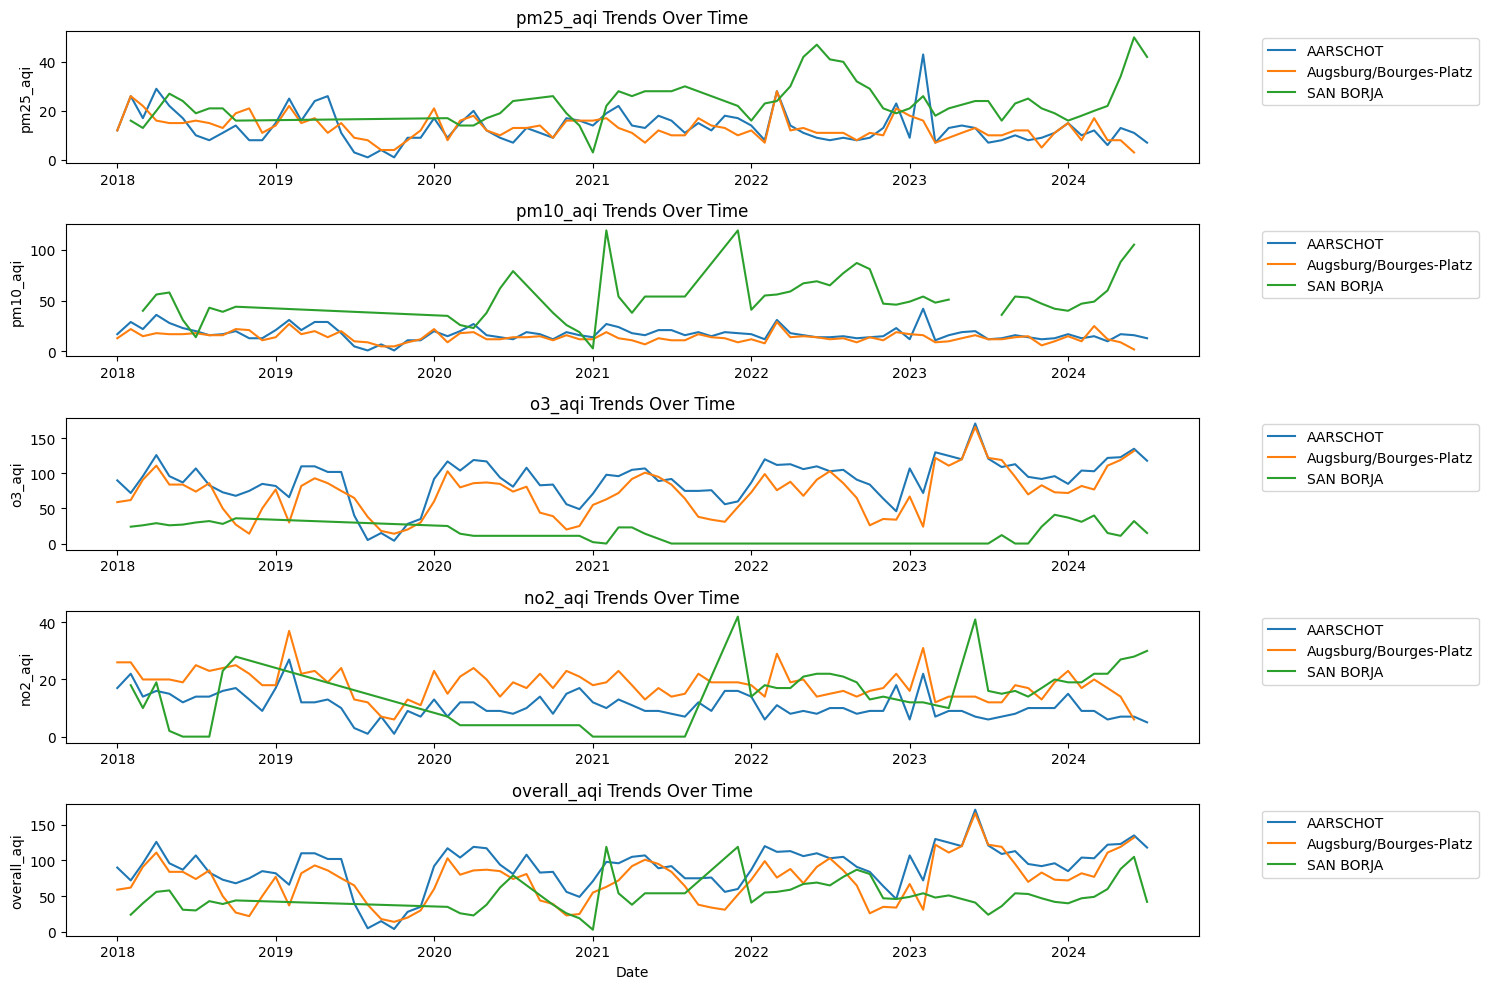

In [15]:
# Time series plots
plt.figure(figsize=(15, 10))
for i, param in enumerate(parameters, 1):
    plt.subplot(len(parameters), 1, i)
    for city in fnew['name'].unique():
        city_data = fnew[fnew['name'] == city]
        plt.plot(city_data['date'], city_data[param], label=city)
    plt.ylabel(param)
    if i == len(parameters):
        plt.xlabel('Date')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'{param} Trends Over Time')
plt.tight_layout()
plt.show()


##### Parameter trends with in a city
- This helps understand which parameter has significant effect in a particular city

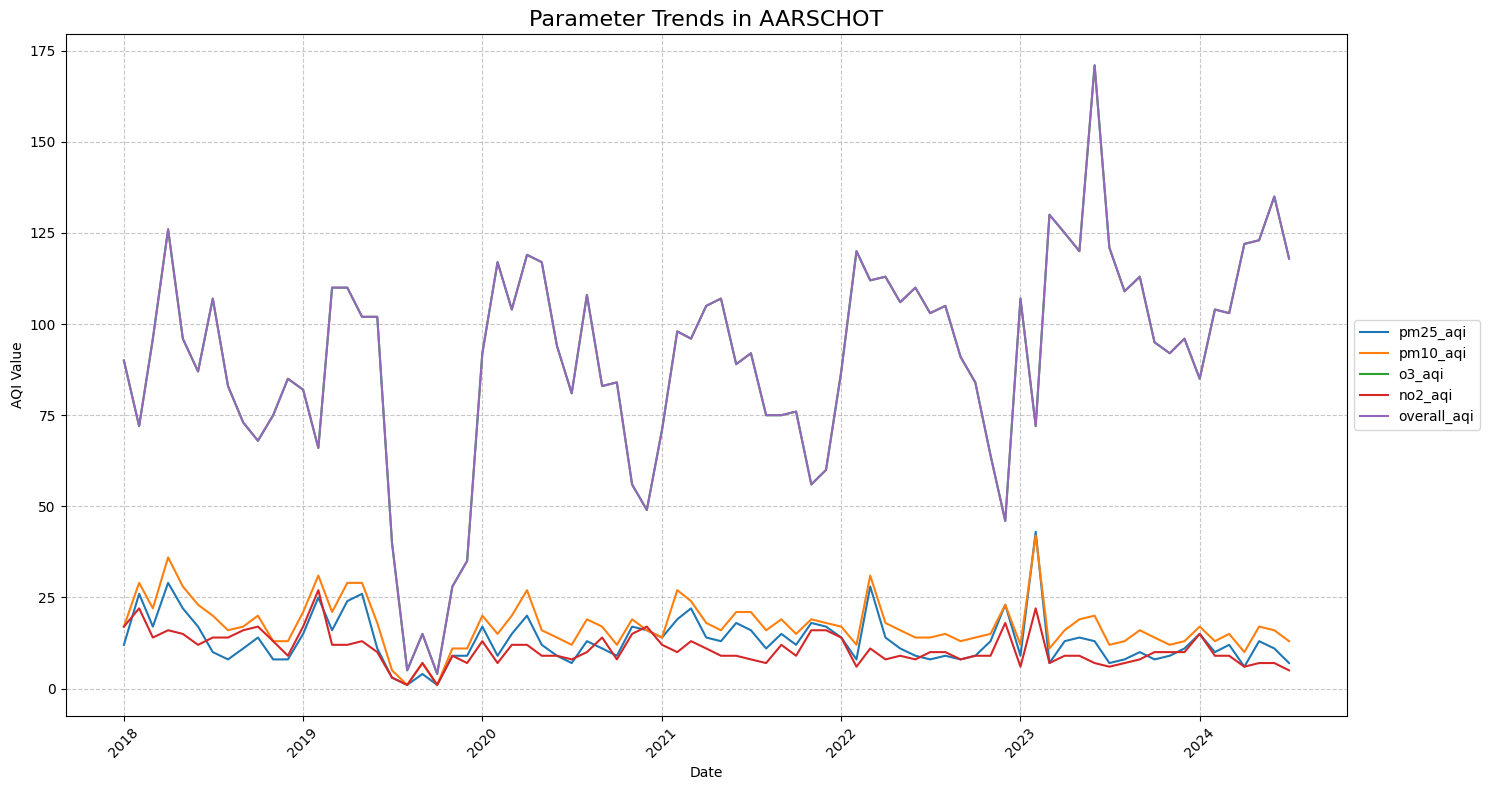

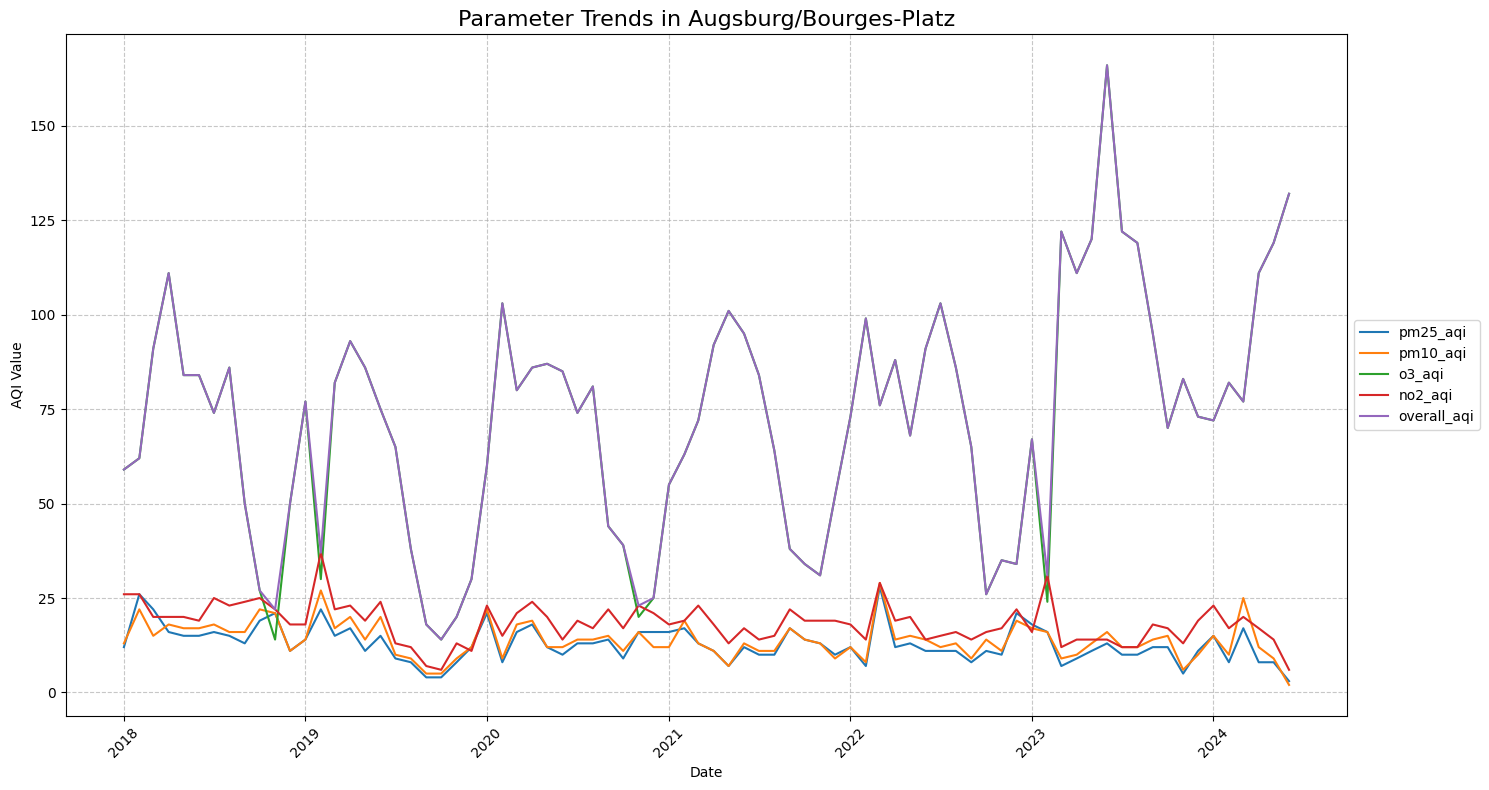

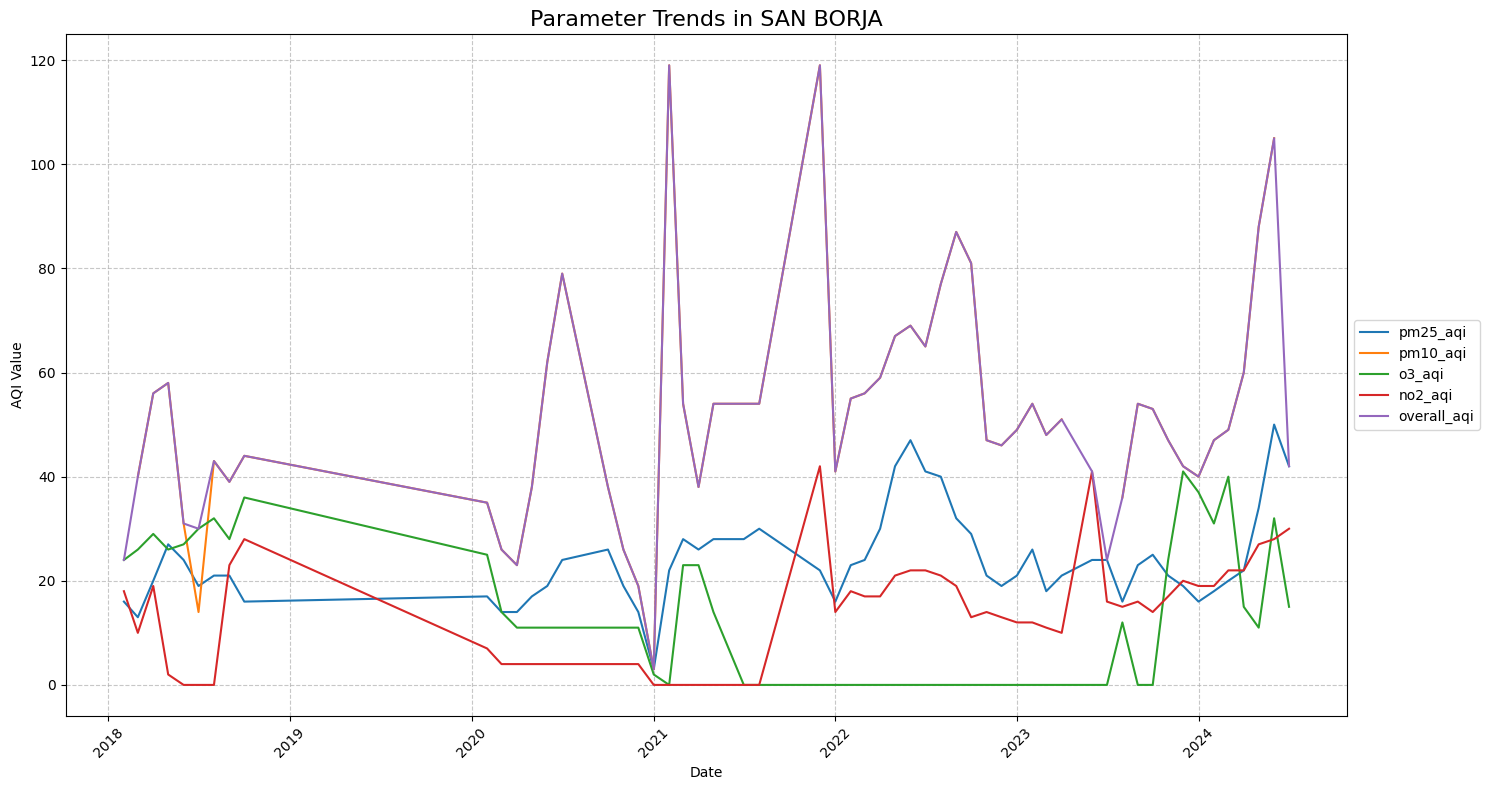

In [16]:
# Comparison of parameter trends within each city using a single plot
for city in fnew['name'].unique():
    city_data = fnew[fnew['name'] == city]
    
    plt.figure(figsize=(15, 8))
    for param in parameters:
        plt.plot(city_data['date'], city_data[param], label=param)
    
    plt.title(f'Parameter Trends in {city}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('AQI Value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Plotting monthly variations
- Understanding the monthly variations of the aqi across the cities

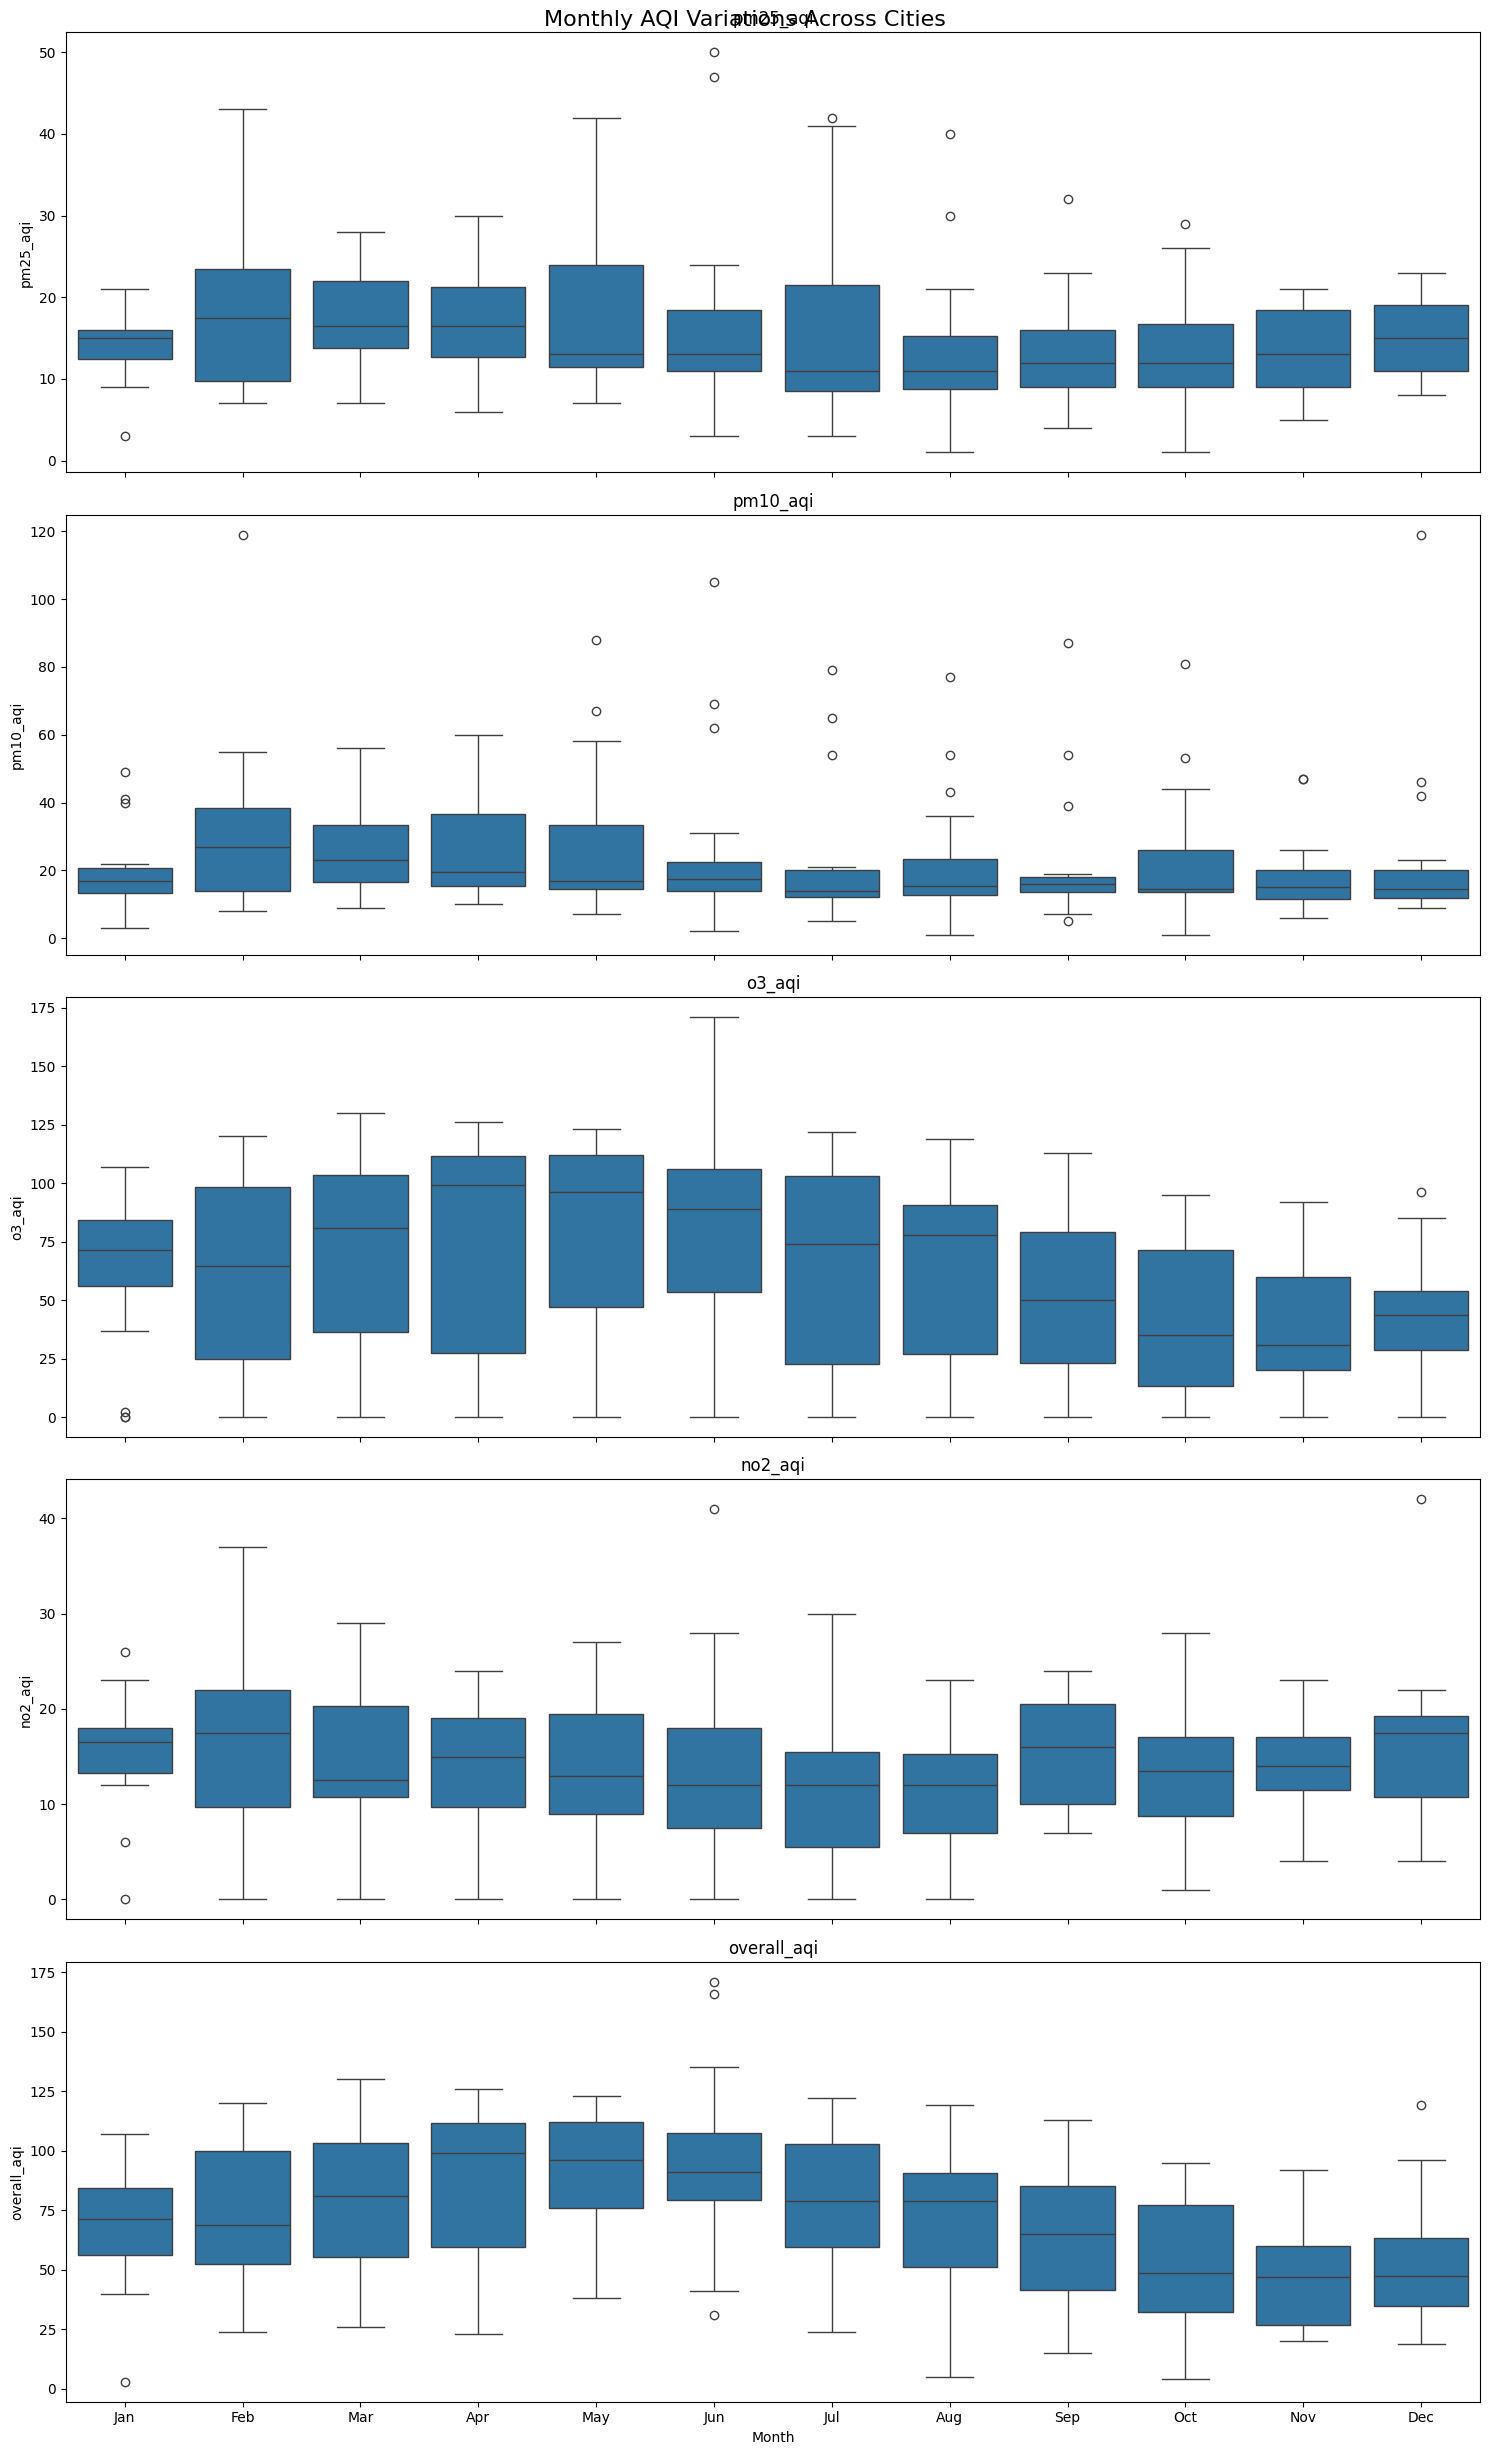

In [17]:
# 2. Box plot for monthly variations across cities
fnew['month'] = fnew['date'].dt.strftime('%b')  # Convert to Jan, Feb, etc. format
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(len(parameters), 1, figsize=(15, 5*len(parameters)), sharex=True)
fig.suptitle('Monthly AQI Variations Across Cities', fontsize=16)

for i, param in enumerate(parameters):
    sns.boxplot(x='month', y=param, data=fnew, ax=axes[i], order=month_order)
    axes[i].set_title(param)
    axes[i].set_xlabel('')

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

#### Line plots to visualize the average AQI trends throughout the years

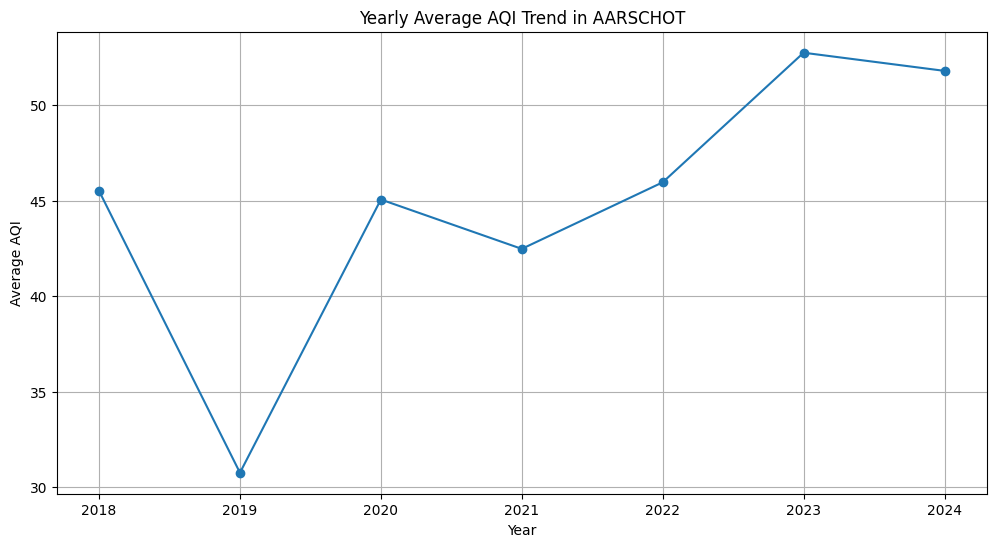

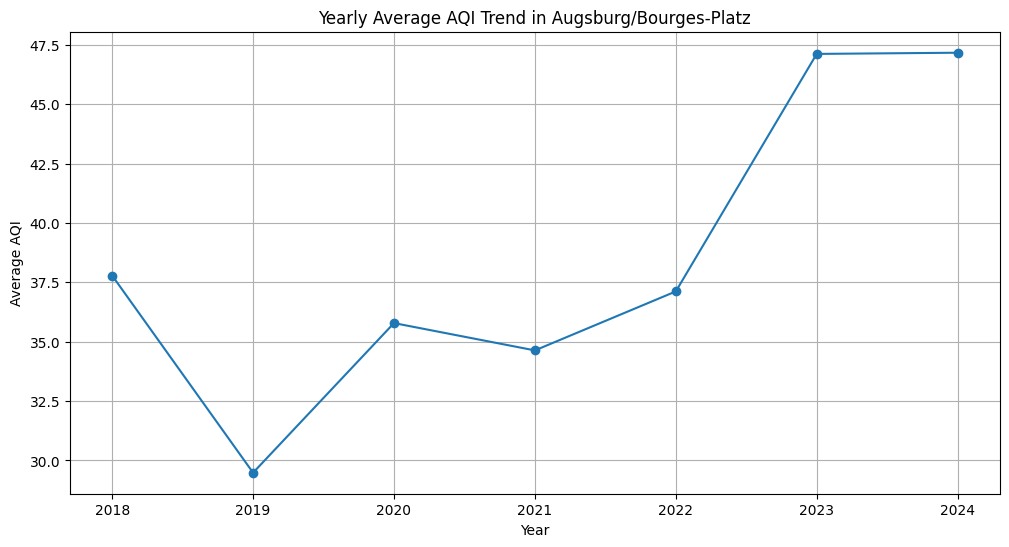

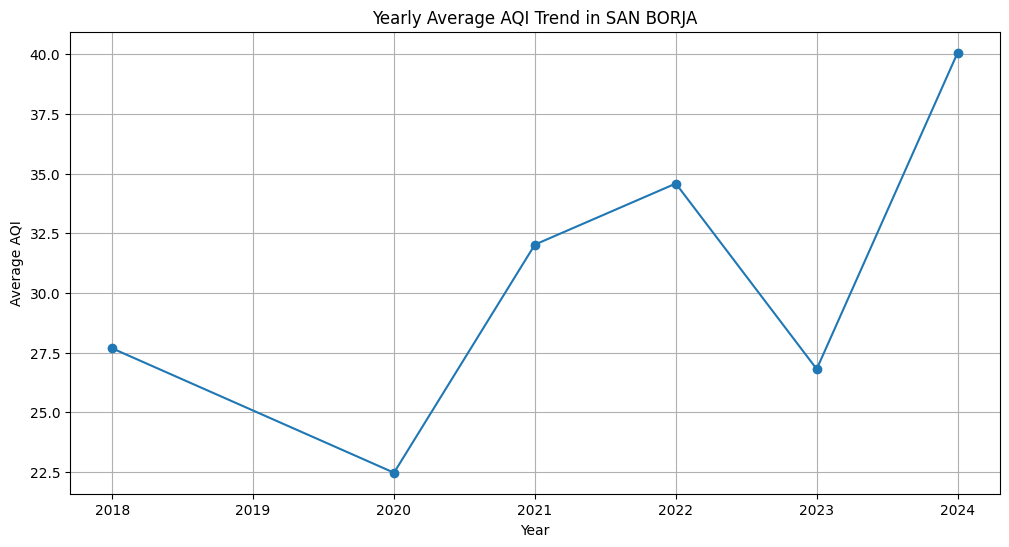

In [18]:
# 3. Line plots for each city showing the trend of average AQI through years
fnew['year'] = fnew['date'].dt.year
fnew['avg_aqi'] = fnew[parameters].mean(axis=1)

for city in fnew['name'].unique():
    city_data = fnew[fnew['name'] == city]
    yearly_avg = city_data.groupby('year')['avg_aqi'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_avg['year'], yearly_avg['avg_aqi'], marker='o')
    plt.title(f'Yearly Average AQI Trend in {city}')
    plt.xlabel('Year')
    plt.ylabel('Average AQI')
    plt.grid(True)
    plt.show()

##### To have an insight of the trend in 2023

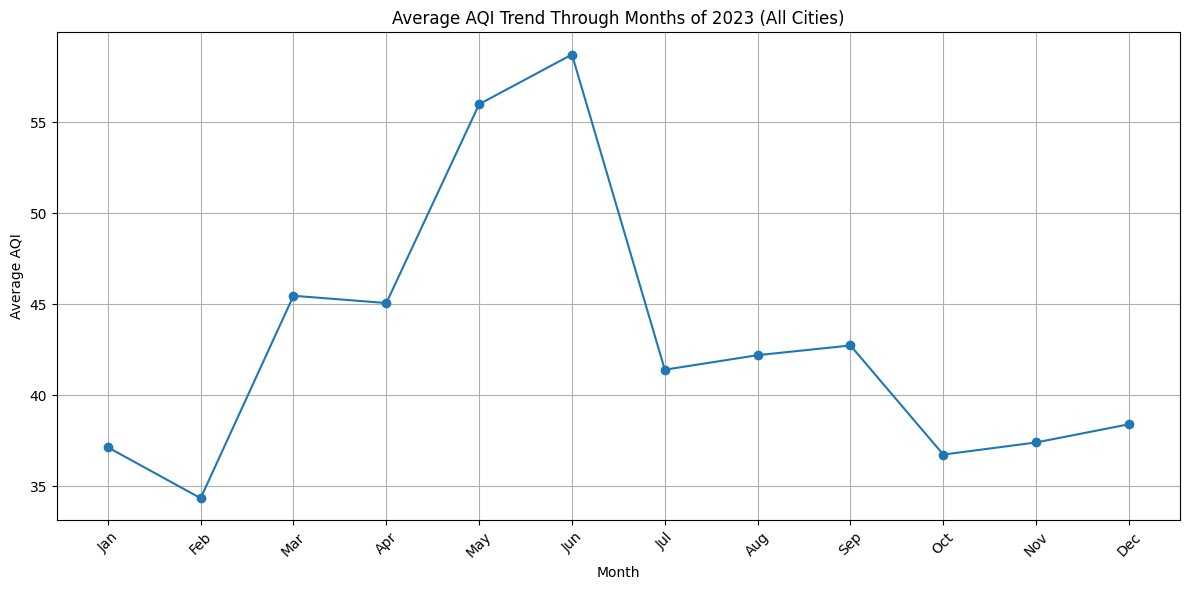

In [19]:
# 4. Line graph showing the trend of average AQI through months of 2023
data_2023 = fnew[fnew['date'].dt.year == 2023]
monthly_avg_2023 = data_2023.groupby('month')[parameters].mean().reindex(month_order)
overall_avg_2023 = monthly_avg_2023.mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(month_order, overall_avg_2023, marker='o')
plt.title('Average AQI Trend Through Months of 2023 (All Cities)')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Monthly AQI variation throughout the years

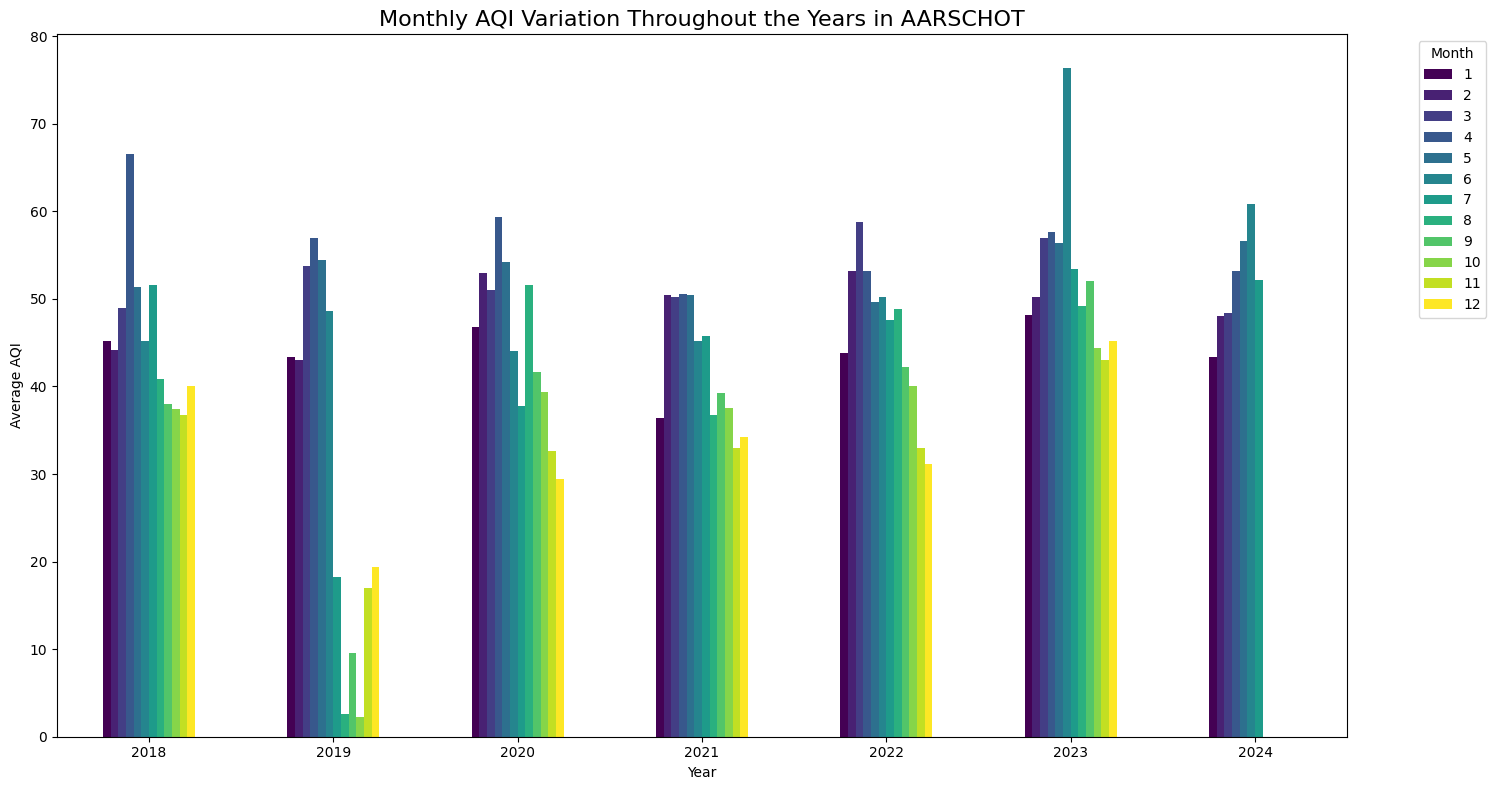

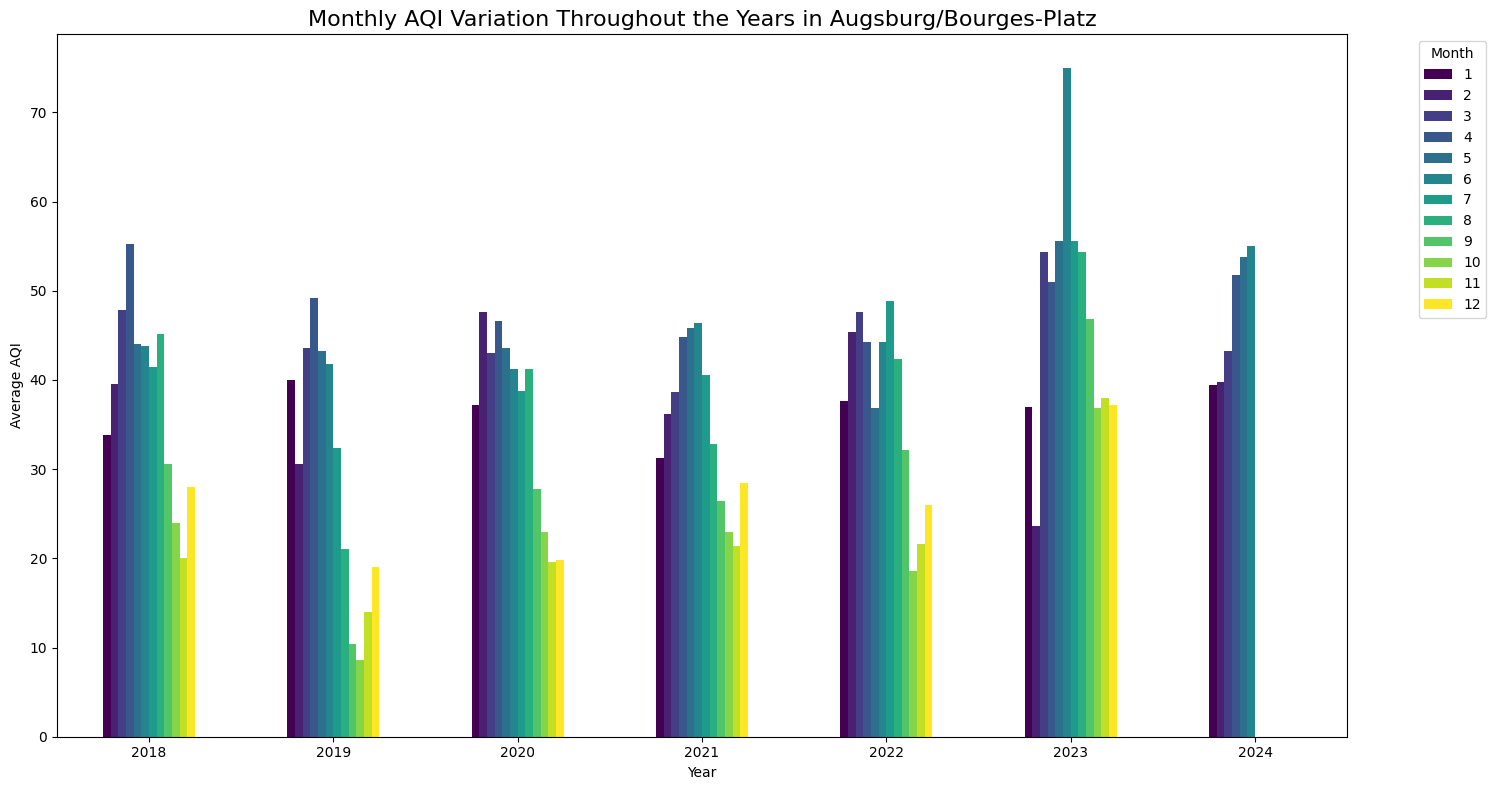

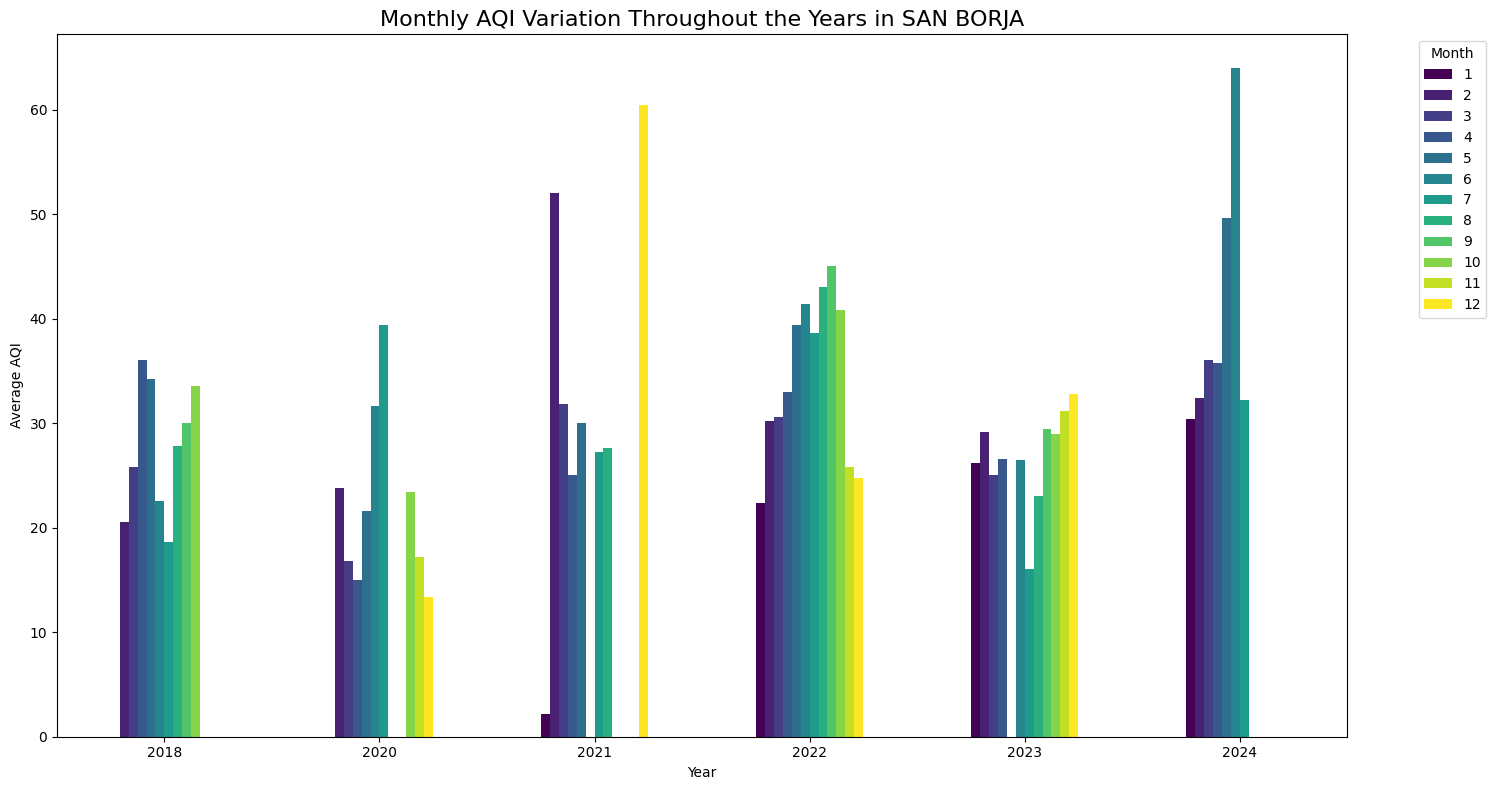

In [20]:
# Ensure 'date' column is in datetime format
fnew['date'] = pd.to_datetime(fnew['date'])

# Step 1: Calculate the monthly average AQI for each city
fnew['month'] = fnew['date'].dt.strftime('%b')  # Convert to Jan, Feb, etc. format
fnew['year'] = fnew['date'].dt.year

# If 'AQI' is not a direct column, calculate an average AQI from the parameters
if 'AQI' not in fnew.columns:
    fnew['AQI'] = fnew[parameters].mean(axis=1)

# Calculate monthly average AQI for each city
monthly_avg = fnew.groupby(['name', 'year', 'month'])['AQI'].mean().reset_index()

# Convert the 'month' column back to an integer format for proper sorting
fnew['month_num'] = fnew['date'].dt.month

# Step 2: Plot a bar graph for each city showing the monthly variations of AQI throughout the years
for city in fnew['name'].unique():
    city_data = fnew[fnew['name'] == city]
    monthly_avg_city = city_data.groupby(['year', 'month_num'])['AQI'].mean().reset_index()

    # Pivot the data to get months as columns and years as rows
    monthly_avg_city_pivot = monthly_avg_city.pivot(index='year', columns='month_num', values='AQI')
    monthly_avg_city_pivot = monthly_avg_city_pivot.reindex(columns=range(1, 13))  # Ensure all months are included

    # Plotting the bar graph
    monthly_avg_city_pivot.plot(kind='bar', figsize=(15, 8), colormap='viridis')
    plt.title(f'Monthly AQI Variation Throughout the Years in {city}', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Average AQI')
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
